# Salary Classification Visualization

Import Libraries

In [240]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

Open Files

In [241]:
train = pd.read_csv('C:/Users/matth/Downloads/au_train.csv')
test = pd.read_csv('C:/Users/matth/Downloads/au_test.csv')
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocess Data

Check for null values

In [242]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  class           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Rename "class" column to "salary"

In [243]:
train = train.rename(columns={'class': 'salary'})
test = test.rename(columns={'class': 'salary'})

Strip leading whitespace in object (string) columns

In [244]:
train = train.applymap(lambda x: x.strip() if isinstance(x, str) else x)
test = test.applymap(lambda x: x.strip() if isinstance(x, str) else x)
test['salary'] = test['salary'].map(lambda x: x.rstrip('.'))

Count number of "?" in columns

In [245]:
train[train == '?'].count()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
salary               0
dtype: int64

In [246]:
test[test == '?'].count()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
salary              0
dtype: int64

Replace "?" values with "unknown"

In [247]:
train.replace(to_replace = '?', value = 'unknown', inplace = True)
train.isin(['?']).any(0)

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
salary            False
dtype: bool

In [248]:
test.replace(to_replace = '?', value = 'unknown', inplace = True)
test.isin(['?']).any(0)

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
salary            False
dtype: bool

Convert all education levels below HS-grad into a single category

In [249]:
list(train['education'].unique())

['Bachelors',
 'HS-grad',
 '11th',
 'Masters',
 '9th',
 'Some-college',
 'Assoc-acdm',
 'Assoc-voc',
 '7th-8th',
 'Doctorate',
 'Prof-school',
 '5th-6th',
 '10th',
 '1st-4th',
 'Preschool',
 '12th']

In [250]:
train['education'].value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

In [251]:
train.replace(to_replace = ['Preschool','1st-4th','5th-6th','7th-8th', '9th', '10th', 
                           '11th', '12th'], value = 'Below-HS', inplace = True)
test.replace(to_replace = ['Preschool','1st-4th','5th-6th','7th-8th', '9th', '10th', 
                           '11th', '12th'], value = 'Below-HS', inplace = True)
train['education'].value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Below-HS         4253
Masters          1723
Assoc-voc        1382
Assoc-acdm       1067
Prof-school       576
Doctorate         413
Name: education, dtype: int64

## Visualizations

In [252]:
def two_class_plot(df, variable):
    N = len(df[variable].unique())
    Up_50K = df[df.salary=='>50K'].groupby(variable)[variable].count()
    Down_50K = df[df.salary=='<=50K'].groupby(variable)[variable].count()
    ind = np.arange(N)    
    width = 0.35       
    result = pd.concat([Down_50K, Up_50K], axis=1)
    result.columns = ['Down_50K', 'Up_50K']
    result = result.fillna(0)
    
    if variable == 'native-country':
        result.drop(index='United-States', inplace=True)
        N = len(result.index)
        ind = np.arange(N)
        plt.figure(num=None, figsize=(14,8), dpi=80, facecolor='w', edgecolor='k')
        p1 = plt.barh(ind, result['Down_50K'], width)
        p2 = plt.barh(ind, result['Up_50K'], width,left=result['Down_50K'])

        plt.xlabel('counts')
        plt.title( variable+' categories in two income classes',fontsize=15)
        plt.yticks(ind, list(result.index))
        plt.legend((p1[0], p2[0]), ('<=50K', '>50K'))
        plt.show()        
        
    else:    
        if variable == 'education':
            result = result.reindex(['Below-HS', 'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 
                                     'Bachelors', 'Masters', 'Prof-school', 'Doctorate'])

        plt.figure(num=None, figsize=(20,4), dpi=80, facecolor='w', edgecolor='k')
        p1 = plt.bar(ind, result['Down_50K'], width)
        p2 = plt.bar(ind, result['Up_50K'], width,bottom=result['Down_50K'])

        plt.ylabel('counts')
        plt.title( variable+' categories in two income classes',fontsize=15)
        plt.xticks(ind, list(result.index))
        plt.legend((p1[0], p2[0]), ('<=50K', '>50K'))
        plt.show()

Income class split based on workclass. Not a strong predictor as the ratios of >50K to <=50K aren't drastically different amonst categories

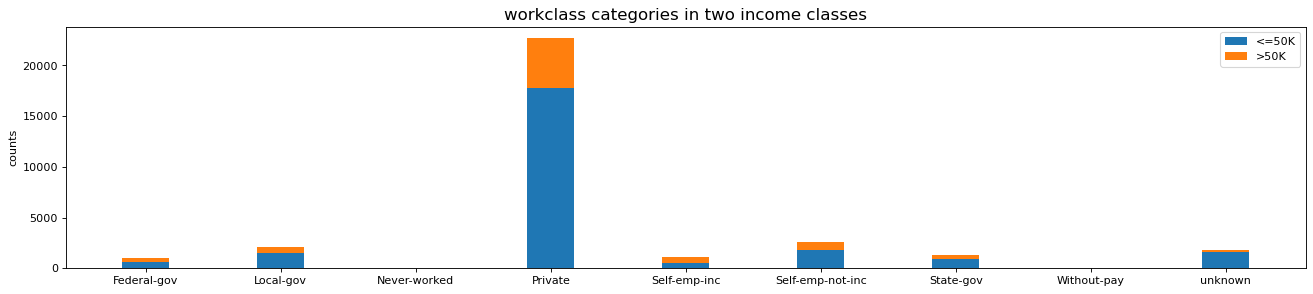

In [253]:
two_class_plot(train,'workclass')

Income class split based on education. A good predictor as higher education levels led to higher ratios of >50K to <=50K

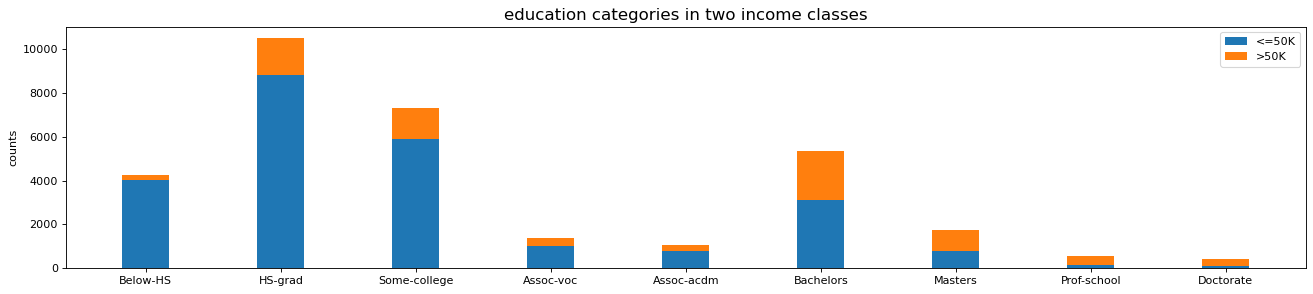

In [254]:
two_class_plot(train,'education')

Income class split based on marital status. Good predictor as categories other than Married-civ-spouse had low ratios of >50K to <=50K

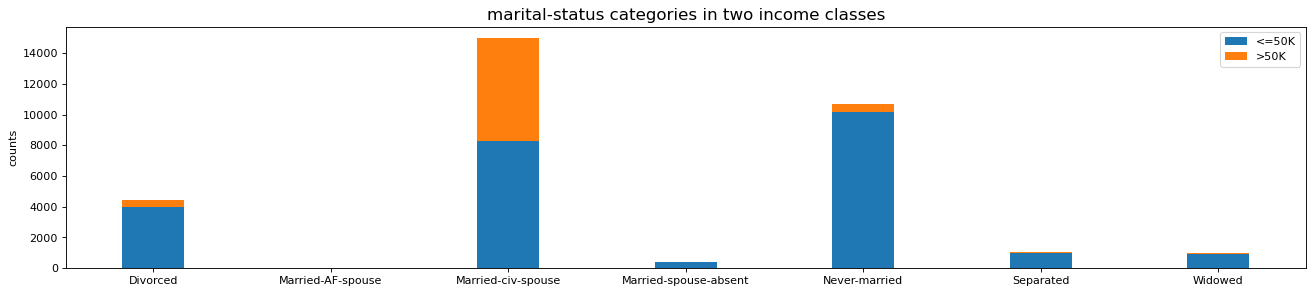

In [255]:
two_class_plot(train,'marital-status')

Income class split based on occupation. Good predictor as Prof-specialty and Exec-manager categories had much higher ratios of >50K to <=50K

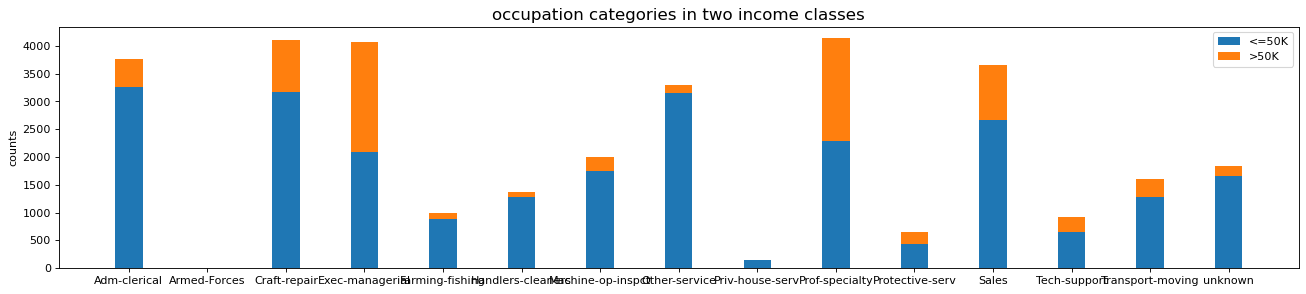

In [256]:
two_class_plot(train,'occupation')

Income class split based on relationship. Good predictor as Husband and Wife categories had much higher ratios of >50K to <=50K

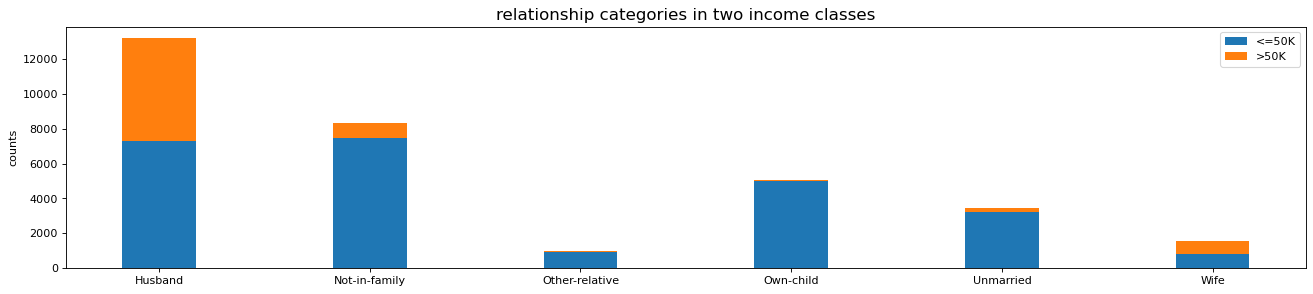

In [257]:
two_class_plot(train,'relationship')

Income class split based on race (with and without White). Pretty good predictor as White category has much higher ratios of >50K to <=50K

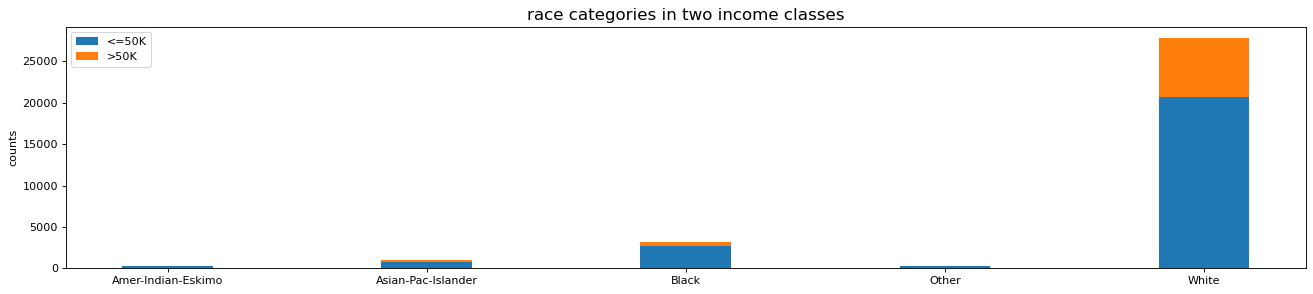

In [258]:
two_class_plot(train,'race')

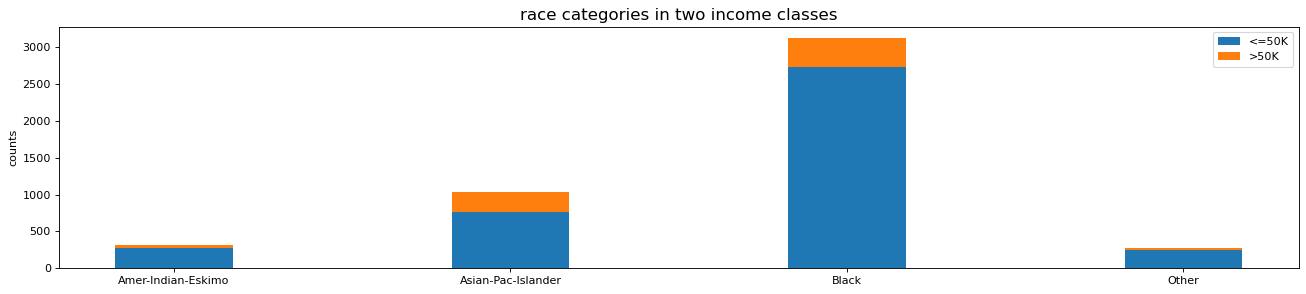

In [259]:
two_class_plot(train[train['race'] != 'White'],'race')

Income class split based on sex. Good predictor as Male categorie had much higher ratios of >50K to <=50K

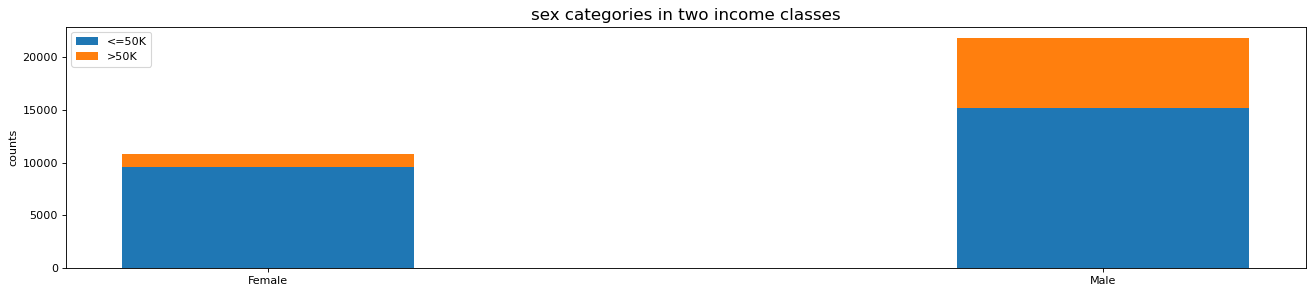

In [260]:
two_class_plot(train,'sex')

Income class split based on native-country (excluding USA)

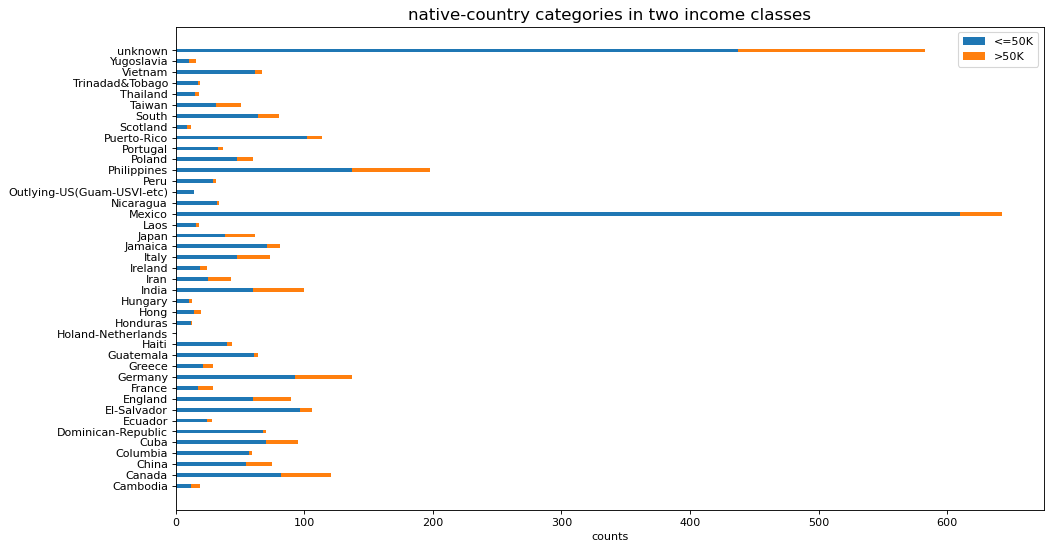

In [261]:
two_class_plot(train,'native-country')